In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE

# Load the credit card dataset
creditcard_df = pd.read_csv('C:\\Users\\HP\\OneDrive\\Desktop\\ai2\\kaim-week-08\\data\\Cleaned_Credit_Card_Data.csv')
print("Credit Card Dataset (first 5 rows):")
print(creditcard_df.head())

# Separate features and target ('Class')
X_credit = creditcard_df.drop(columns=['Class'])
y_credit = creditcard_df['Class']

# Split into train and test sets (80/20 split, with stratification to maintain the class imbalance in test set)
X_credit_train, X_credit_test, y_credit_train, y_credit_test = train_test_split(
    X_credit, y_credit, test_size=0.2, random_state=42, stratify=y_credit
)

# Scale the features
scaler_credit = StandardScaler()
X_credit_train_scaled = scaler_credit.fit_transform(X_credit_train)
X_credit_test_scaled = scaler_credit.transform(X_credit_test)

print("Data preprocessing completed successfully!")
print("Training set shape:", X_credit_train_scaled.shape)
print("Test set shape:", X_credit_test_scaled.shape)
print("Training class distribution:\n", y_credit_train.value_counts())
print("Test class distribution:\n", y_credit_test.value_counts())

# Apply SMOTE to the training data only to balance the classes
smote = SMOTE(random_state=42)
X_credit_train_res, y_credit_train_res = smote.fit_resample(X_credit_train_scaled, y_credit_train)

# Check the new class distribution in the training set
print("After SMOTE:")
print("Count of class 0:", sum(y_credit_train_res == 0))
print("Count of class 1:", sum(y_credit_train_res == 1))


Credit Card Dataset (first 5 rows):
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010 

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Initialize and train the Logistic Regression model
lr_credit = LogisticRegression(max_iter=1000, random_state=42)
lr_credit.fit(X_credit_train_res, y_credit_train_res)

# Predict on the original (imbalanced) test set
y_pred = lr_credit.predict(X_credit_test_scaled)

# Evaluate the model
acc = accuracy_score(y_credit_test, y_pred)
print("\n--- Logistic Regression Model Evaluation on Credit Card Data ---")
print("Accuracy:", acc)
print("Classification Report:\n", classification_report(y_credit_test, y_pred))



--- Logistic Regression Model Evaluation on Credit Card Data ---
Accuracy: 0.9736721531033025
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99     56651
           1       0.05      0.87      0.10        95

    accuracy                           0.97     56746
   macro avg       0.53      0.92      0.54     56746
weighted avg       1.00      0.97      0.99     56746



  0%|          | 0/50 [00:00<?, ?it/s]

Type of shap_values: <class 'numpy.ndarray'>
Shape of shap_values_positive: (50, 30)
Shape of X_credit_test_scaled[:50]: (50, 30)
Length of feature_names: 30


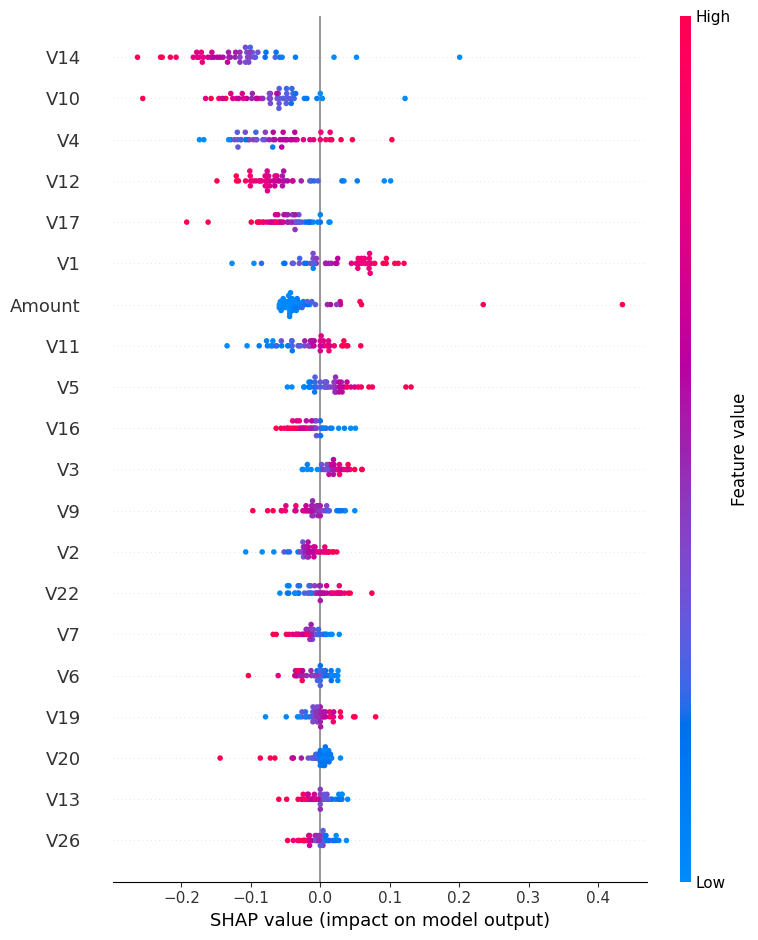

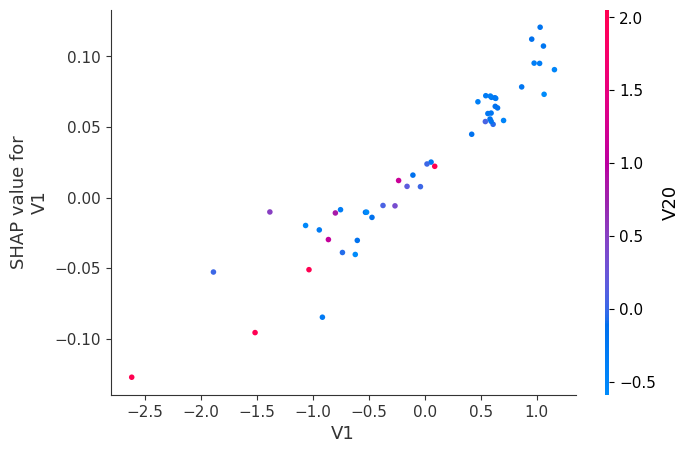

In [5]:
import shap
import numpy as np

# Use a random subset of the SMOTE-resampled training data as background for SHAP
background = X_credit_train_res[np.random.choice(X_credit_train_res.shape[0], 100, replace=False)]

# Create a KernelExplainer using the predict_proba function of the model
explainer = shap.KernelExplainer(lr_credit.predict_proba, background)

# Calculate SHAP values for the first 50 test samples
shap_values = explainer.shap_values(X_credit_test_scaled[:50])

# Debugging: Print the type and shape of shap_values
print(f"Type of shap_values: {type(shap_values)}")
if isinstance(shap_values, list):
    print(f"Length of shap_values: {len(shap_values)}")
    for i, sv in enumerate(shap_values):
        print(f"Shape of shap_values[{i}]: {sv.shape}")

# Convert shap_values to a numpy array
shap_values_array = np.array(shap_values)  # Shape: (50, 30, 2)

# Extract SHAP values for the positive class (class 1)
shap_values_positive = shap_values_array[:, :, 1] 

# Verify the shape
print(f"Shape of shap_values_positive: {shap_values_positive.shape}") 

# Verify input data
print(f"Shape of X_credit_test_scaled[:50]: {X_credit_test_scaled[:50].shape}")
print(f"Length of feature_names: {len(X_credit.columns.tolist())}")

# Plot SHAP Summary Plot for the positive class (class 1)
shap.summary_plot(shap_values_positive, X_credit_test_scaled[:50], feature_names=X_credit.columns.tolist())

# Plot SHAP Force Plot for the first instance (for class 'Fraud')
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values_positive[0, :], feature_names=X_credit.columns.tolist())

# Plot SHAP Dependence Plot for a specific feature ( 'V1')
shap.dependence_plot("V1", shap_values_positive, X_credit_test_scaled[:50], feature_names=X_credit.columns.tolist())

In [9]:
# --- LIME Explainability ---

from lime.lime_tabular import LimeTabularExplainer

# Set up LIME with training data
explainer_lime = LimeTabularExplainer(
    X_credit_train_scaled,
    feature_names=X_credit.columns.tolist(),
    class_names=['Non-Fraud', 'Fraud'],
    discretize_continuous=True
)

# Explain the first test instance
i = 0  # index of the instance to explain
exp = explainer_lime.explain_instance(
    X_credit_test_scaled[i],
    lr_credit.predict_proba,
    num_features=10
)

# Visualize LIME explanation (in Jupyter Notebook)
exp.show_in_notebook(show_table=True)


# save LIME explanation to HTML
exp.save_to_file('lime_explanation.html')


In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE


# Load the fraud data dataset
fraud_df = pd.read_csv('C:\\Users\\HP\\OneDrive\\Desktop\\ai2\\kaim-week-08\\data\\Cleaned_Fraud_Data.csv')
print("\nFraud Data Dataset (first 5 rows):")
print(fraud_df.head())

# Convert date columns to datetime
fraud_df['signup_time'] = pd.to_datetime(fraud_df['signup_time'])
fraud_df['purchase_time'] = pd.to_datetime(fraud_df['purchase_time'])

# Create a new feature: time (in hours) from signup to purchase
fraud_df['time_to_purchase'] = (fraud_df['purchase_time'] - fraud_df['signup_time']).dt.total_seconds() / 3600

# Drop the original date columns (or keep them if further processing is desired)
fraud_df = fraud_df.drop(columns=['signup_time', 'purchase_time'])

# Convert ip_address to numeric (if not already)
fraud_df['ip_address'] = pd.to_numeric(fraud_df['ip_address'], errors='coerce')

# Identify categorical columns that need encoding
categorical_cols = ['device_id', 'source', 'browser', 'sex', 'country']

# Function to reduce unique categories for high-cardinality columns
def reduce_categories(df, column, threshold=50):
    top_categories = df[column].value_counts().nlargest(threshold).index
    df[column] = df[column].apply(lambda x: x if x in top_categories else "Other")
    return df

# Reduce unique values for high-cardinality categorical columns
for col in categorical_cols:
    fraud_df = reduce_categories(fraud_df, col, threshold=50)

# Apply one-hot encoding after reducing unique categories
fraud_df = pd.get_dummies(fraud_df, columns=categorical_cols, drop_first=True)

# Separate features and target ('class')
X_fraud = fraud_df.drop(columns=['class'])
y_fraud = fraud_df['class']

# Split into train and test sets with stratification
X_fraud_train, X_fraud_test, y_fraud_train, y_fraud_test = train_test_split(
    X_fraud, y_fraud, test_size=0.2, random_state=42, stratify=y_fraud
)

# Scale the fraud dataset features
scaler_fraud = StandardScaler()
X_fraud_train_scaled = scaler_fraud.fit_transform(X_fraud_train)
X_fraud_test_scaled = scaler_fraud.transform(X_fraud_test)

print("Data preprocessing completed successfully!")
print("Training set shape:", X_fraud_train_scaled.shape)
print("Test set shape:", X_fraud_test_scaled.shape)
print("Training class distribution:\n", y_fraud_train.value_counts())
print("Test class distribution:\n", y_fraud_test.value_counts())

# Addressing Imbalance with SMOTE
# Apply SMOTE to the training data only

smote = SMOTE(random_state=42)
X_fraud_train_res, y_fraud_train_res = smote.fit_resample(X_fraud_train_scaled, y_fraud_train)

print("\nAfter applying SMOTE on the training data:")
print("Resampled training set shape:", X_fraud_train_res.shape)
print("Resampled class distribution:")
print("Class 0 count:", sum(y_fraud_train_res == 0))
print("Class 1 count:", sum(y_fraud_train_res == 1))



Fraud Data Dataset (first 5 rows):
   user_id          signup_time        purchase_time  purchase_value  \
0   247547  2015-06-28 03:00:34  2015-08-09 03:57:29              47   
1   220737  2015-01-28 14:21:11  2015-02-11 20:28:28              15   
2   390400  2015-03-19 20:49:09  2015-04-11 23:41:23              44   
3    69592  2015-02-24 06:11:57  2015-05-23 16:40:14              55   
4   174987  2015-07-07 12:58:11  2015-11-03 04:04:30              51   

       device_id  source browser sex  age    ip_address  class    ip_int  \
0  KIXYSVCHIPQBR     SEO  Safari   F   30  1.677886e+07      0  16778864   
1  PKYOWQKWGJNJI     SEO  Chrome   F   34  1.684205e+07      0  16842046   
2  LVCSXLISZHVUO     Ads      IE   M   29  1.684366e+07      0  16843657   
3  UHAUHNXXUADJE  Direct  Chrome   F   30  1.693873e+07      0  16938733   
4  XPGPMOHIDRMGE     SEO  Chrome   F   37  1.697198e+07      0  16971984   

   lower_bound_ip_address  upper_bound_ip_address    country  purchase_hou

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Initialize and train the Logistic Regression model
lr_fraud = LogisticRegression(max_iter=1000, random_state=42)
lr_fraud.fit(X_fraud_train_res, y_fraud_train_res)

# Predict on the original (imbalanced) test set
y_pred = lr_fraud.predict(X_fraud_test_scaled)

# Evaluate the model
acc = accuracy_score(y_fraud_test, y_pred)
print("\n--- Logistic Regression Model Evaluation on Credit Card Data ---")
print("Accuracy:", acc)
print("Classification Report:\n", classification_report(y_fraud_test, y_pred))



--- Logistic Regression Model Evaluation on Credit Card Data ---
Accuracy: 0.6766550522648084
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.67      0.79     23376
           1       0.18      0.69      0.29      2454

    accuracy                           0.68     25830
   macro avg       0.57      0.68      0.54     25830
weighted avg       0.88      0.68      0.74     25830



  0%|          | 0/50 [00:00<?, ?it/s]

Type of shap_values: <class 'numpy.ndarray'>
Shape of shap_values_positive: (50, 118)
Shape of X_fraud_test_scaled[:50]: (50, 118)
Length of feature_names: 118


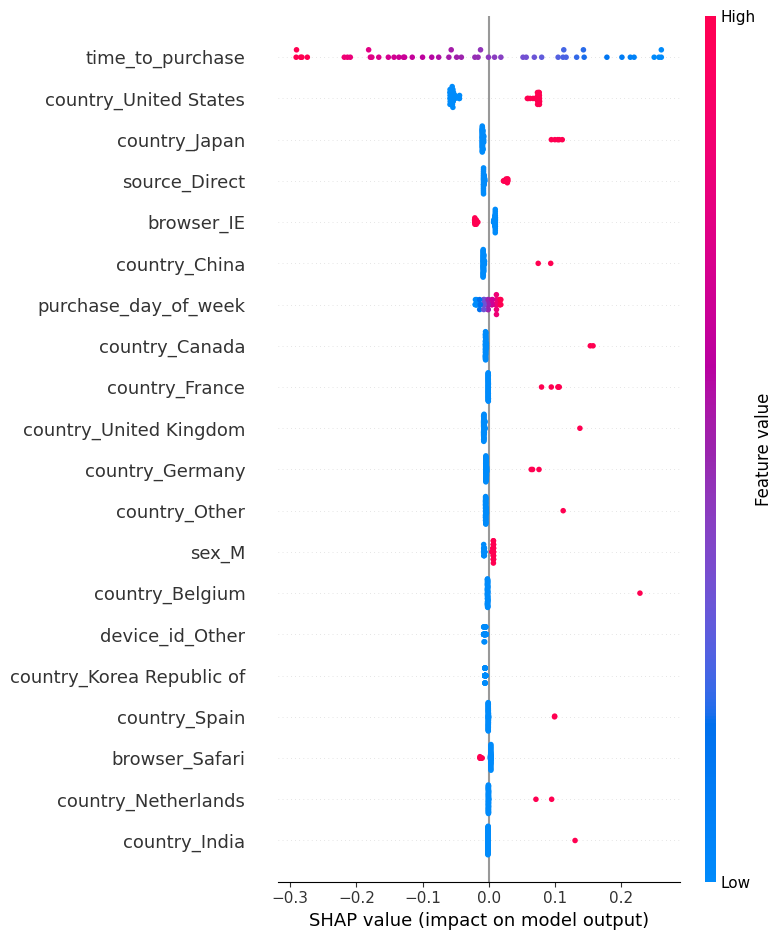

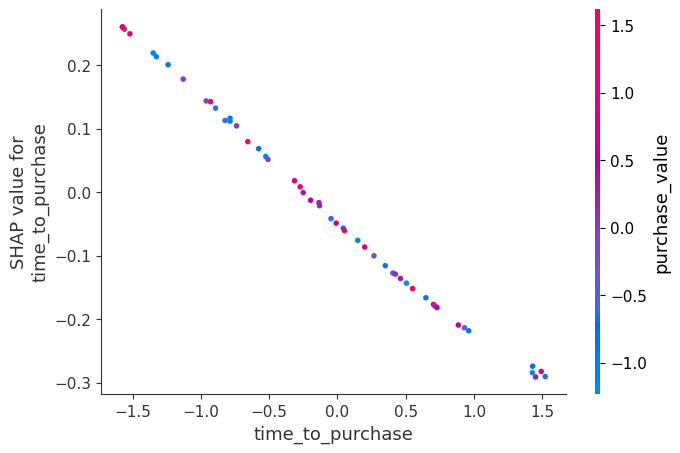

In [12]:
import shap
import numpy as np

# Use a random subset of the SMOTE-resampled training data as background for SHAP
background = X_fraud_train_res[np.random.choice(X_fraud_train_res.shape[0], 100, replace=False)]

# Create a KernelExplainer using the predict_proba function of the model
explainer = shap.KernelExplainer(lr_fraud.predict_proba, background)

# Calculate SHAP values for the first 50 test samples
shap_values = explainer.shap_values(X_fraud_test_scaled[:50])

# Debugging: Print the type and shape of shap_values
print(f"Type of shap_values: {type(shap_values)}")
if isinstance(shap_values, list):
    print(f"Length of shap_values: {len(shap_values)}")
    for i, sv in enumerate(shap_values):
        print(f"Shape of shap_values[{i}]: {sv.shape}")

# Convert shap_values to a numpy array
shap_values_array = np.array(shap_values)  

# Extract SHAP values for the positive class (class 1 - Fraud)
shap_values_positive = shap_values_array[:, :, 1]  

# Verify the shape
print(f"Shape of shap_values_positive: {shap_values_positive.shape}")  

# Verify input data
print(f"Shape of X_fraud_test_scaled[:50]: {X_fraud_test_scaled[:50].shape}")
print(f"Length of feature_names: {len(X_fraud.columns.tolist())}")

# Plot SHAP Summary Plot for the positive class (Fraud)
shap.summary_plot(shap_values_positive, X_fraud_test_scaled[:50], feature_names=X_fraud.columns.tolist())

# Plot SHAP Force Plot for the first instance (for class 'Fraud')
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values_positive[0, :], feature_names=X_fraud.columns.tolist())

# Plot SHAP Dependence Plot for a specific feature ( 'time_to_purchase')
shap.dependence_plot("time_to_purchase", shap_values_positive, X_fraud_test_scaled[:50], feature_names=X_fraud.columns.tolist())


In [13]:
# LIME Explainability

from lime.lime_tabular import LimeTabularExplainer

# Set up LIME with training data
explainer_lime = LimeTabularExplainer(
    X_fraud_train_scaled,
    feature_names=X_fraud.columns.tolist(),
    class_names=['Non-Fraud', 'Fraud'],
    discretize_continuous=True
)

# Explain the first test instance

exp = explainer_lime.explain_instance(
    X_fraud_test_scaled[i],
    lr_fraud.predict_proba,
    num_features=10
)

# Visualize LIME explanation (in Jupyter Notebook)
exp.show_in_notebook(show_table=True)

# Save LIME explanation to an HTML file
exp.save_to_file('lime_explanation_fraud.html')
